In [87]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset
import cv2
import os
import matplotlib.pyplot as plt

(375, 1242, 3)
(375, 1242, 3)
[ 4  7  8 11 12 13 17 20 21 23 24 26 27 28]
[ 4  7  8 11 12 13 17 19 20 21 22 23 24 26 28 31 32]
[ 4  7  8 11 17 19 20 21 22 23 25 26 27 33]
[ 4  7  8 11 17 20 21 22 25 26 27 32 33]
[ 4  7  9 11 13 21 22 23 26 27 33]
[ 0  4  7  9 11 17 20 21 23 26]
[ 0  4  7  8  9 11 17 20 21 22 23 26]
[ 4  7  8 11 17 19 20 21 22 23 24 26 27 33]
[ 4  7  8 11 17 19 20 21 22 23 24 26 33]
[ 0  4  7  8 11 17 19 20 21 22 23 24 26]
[ 4  7  8 11 17 19 20 21 22 23 25 26 33]
[ 4  7  8 11 17 19 20 21 22 23 26]
[ 4  7  8 11 17 19 20 21 22 23 26]
[ 4  6  7  8 11 13 17 19 20 21 22 23 24 26 27 28 33]
[ 0  4  6  7  8 11 13 17 19 20 21 22 23 24 26 27 33]
[ 0  4  7  8 11 13 17 19 20 21 22 23 24 26 27 28 33]
[ 4  7  8 11 12 13 17 19 20 21 22 23 24 26 27 28]
[ 4  7  8 11 13 17 19 20 21 22 23 24 26 28]
[ 4  7  8 11 13 15 17 20 21 22 23 26 27]
[ 4  7  8 11 12 13 15 17 21 22 23 26 27]
[ 4  7  8 11 13 15 17 20 21 22 23 24 26]
[ 4  7 11 13 15 17 21 22 23 26]
[ 4  7  8 10 12 13 17 19 20 21 22 23 2

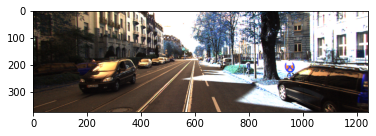

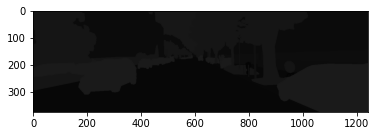

In [81]:
DATA_PATH = "../../data/"
SEMANTICS_PATH = os.path.join(DATA_PATH, "data_semantics")
TRAIN_PATH = os.path.join(SEMANTICS_PATH, "training")
TRAIN_RGB_PATH = os.path.join(TRAIN_PATH, "image_2")
TRAIN_SEMANTIC_PATH = os.path.join(TRAIN_PATH, "semantic")

rgbs = os.listdir(TRAIN_RGB_PATH)
semantics = os.listdir(TRAIN_SEMANTIC_PATH)

x = cv2.imread(os.path.join(TRAIN_RGB_PATH, rgbs[0]))
plt.figure()
plt.imshow(x)
print(x.shape)

x = cv2.imread(os.path.join(TRAIN_SEMANTIC_PATH, semantics[0]))
plt.figure()
plt.imshow(x)
print(x.shape)

for i in range(60):
    x = cv2.imread(os.path.join(TRAIN_SEMANTIC_PATH, semantics[i]))
    print(np.unique(x))

In [102]:
class KITTI_SEG(Dataset):
    def __init__(self, rgb_path, label_path, transform=None, target_transform=None):
        self.rgb_path = rgb_path
        self.rgb_names = os.listdir(self.rgb_path)         
        
        self.label_path = label_path
        self.label_names = os.listdir(self.label_path)
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.rgb_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.rgb_path, self.rgb_names[idx])
        semantic_path = os.path.join(self.label_path, self.label_names[idx])        
        
        img = read_image(img_path)
        label = read_image(semantic_path, ImageReadMode.GRAY)
        label = label.squeeze(0)
        
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
            
        return img, label
    
    def example(self):
        image, label = self.__getitem__(3)
        image = image.permute(1, 2, 0)
        print(image.shape)
        print(label.shape)
        plt.figure()
        plt.imshow(image)
        plt.figure()
        plt.imshow(label)        
        
        
dataset = KITTI_SEG(TRAIN_RGB_PATH, TRAIN_SEMANTIC_PATH)


In [62]:
class HorizontalBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(input_dim, output_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)
        self.relu = nn.LeakyReLU(inplace=True)
        self.bn = nn.BatchNorm2d(output_dim)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class DownBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        return self.max_pool(x)
    
class UpBlock(nn.Module):
    def __init__(self, input_dim):
        super().__init__()        
        self.tconv = nn.ConvTranspose2d(input_dim, input_dim//2, kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.tconv(x)
        return x
    
class ContractPath(nn.Module):
    def __init__(self, input_dim):
        super().__init__()        
        self.hb1 = HorizontalBlock(input_dim, 64)
        self.hb2 = HorizontalBlock(64, 128)
        self.hb3 = HorizontalBlock(128, 256)
        self.hb4 = HorizontalBlock(256, 512) 
        self.hb5 = HorizontalBlock(512,1024)         
        
        self.db = DownBlock()
        
    def forward(self, x):
        x1 = self.hb1(x)
        x1c = self.db(x1)
        
        x2 = self.hb2(x1c)
        x2c = self.db(x2)
        
        x3 = self.hb3(x2c)
        x3c = self.db(x3)
        
        x4 = self.hb4(x3c)
        x4c = self.db(x4) 
        
        x5 = self.hb5(x4c)
        return x5, x4, x3, x2, x1
    
class ExpandPath(nn.Module):
    def __init__(self, output_dim):
        super().__init__()        
        self.hb1 = HorizontalBlock(1024, 512)        
        self.hb2 = HorizontalBlock(512, 256)
        self.hb3 = HorizontalBlock(256, 128)
        self.hb4 = HorizontalBlock(128, 64)
        self.out_conv = nn.Conv2d(64, output_dim, kernel_size=1)
        
        self.ub1 = UpBlock(1024)
        self.ub2 = UpBlock(512)
        self.ub3 = UpBlock(256)
        self.ub4 = UpBlock(128)
        
    def forward(self, cp):
        x = cp[0]
        x = self.ub1(x) #512
        
        x_padded = torch.zeros(*cp[1].shape)
        x_padded[:,:,:x.shape[2],:x.shape[3]] = x
        x = torch.cat((x_padded, cp[1]), 1) #1024
        x = self.hb1(x) #512
        x = self.ub2(x) #256
        
        x = torch.cat((x, cp[2]), 1) #512
        x = self.hb2(x) #256
        x = self.ub3(x) #128

        x = torch.cat((x, cp[3]), 1) #256
        x = self.hb3(x) #128
        x = self.ub4(x) #64   

        x = torch.cat((x, cp[4]), 1) #128
        x = self.hb4(x) #64
        
        x = self.out_conv(x) #num class
        
        return x
                    
    
class UNet(nn.Module):
    def __init__(self, input_dim, num_class):
        super().__init__()                
        self.cp = ContractPath(input_dim)
        self.ep = ExpandPath(num_class)

    def forward(self, x):
        feat_maps = self.cp(x)
        y = self.ep(feat_maps)
        return y
        
    
x = torch.randn(1, 3, 480, 360)
unet = UNet(3, 10)
y = unet(x)
print(y.shape)

torch.Size([1, 10, 480, 360])


In [75]:
loss = nn.CrossEntropyLoss()
y = torch.randint(33, (10, 480, 360))
x = torch.randn(10, 33, 480, 360)
print(x.shape, y.shape)
z = loss(x, y)
z

torch.Size([10, 33, 480, 360]) torch.Size([10, 480, 360])


tensor(3.9727)